In [16]:
import toml
import pandas as pd
import seaborn as sns
from pathlib import Path
from aging.plotting import format_plots, figure, legend
from aging.size_norm.util import load_model_parameters
from toolz import groupby, valmap

In [17]:
format_plots()

In [18]:
scan_path = Path('/n/groups/datta/win/longtogeny/size_norm/models/bottleneck_optimization_00/stage_05')

In [19]:
metrics = sorted(scan_path.glob('**/metrics.csv'))
results = load_model_parameters(metrics)
results = results.groupby('file').apply(lambda x: x.loc[x['epoch'] == x['epoch'].max()]).reset_index(drop=True)

In [20]:
results[['file', 'curriculum_learning', 'use_fft', 'arch']]

,file,curriculum_learning,use_fft,arch
0,/n/groups/datta/win/longtogeny/size_norm/model...,False,True,ae
1,/n/groups/datta/win/longtogeny/size_norm/model...,False,False,ae
2,/n/groups/datta/win/longtogeny/size_norm/model...,True,True,ae
3,/n/groups/datta/win/longtogeny/size_norm/model...,True,True,vae
4,/n/groups/datta/win/longtogeny/size_norm/model...,False,False,vae
5,/n/groups/datta/win/longtogeny/size_norm/model...,True,False,vae
6,/n/groups/datta/win/longtogeny/size_norm/model...,True,False,ae
7,/n/groups/datta/win/longtogeny/size_norm/model...,False,True,vae


In [21]:
results.loc[results['arch'] == 'ae', 'combined'] = results['val_mse']
results.loc[results['arch'] == 'vae', 'combined'] = results['vae_val_mse']

<Axes: xlabel='curriculum_learning', ylabel='combined'>

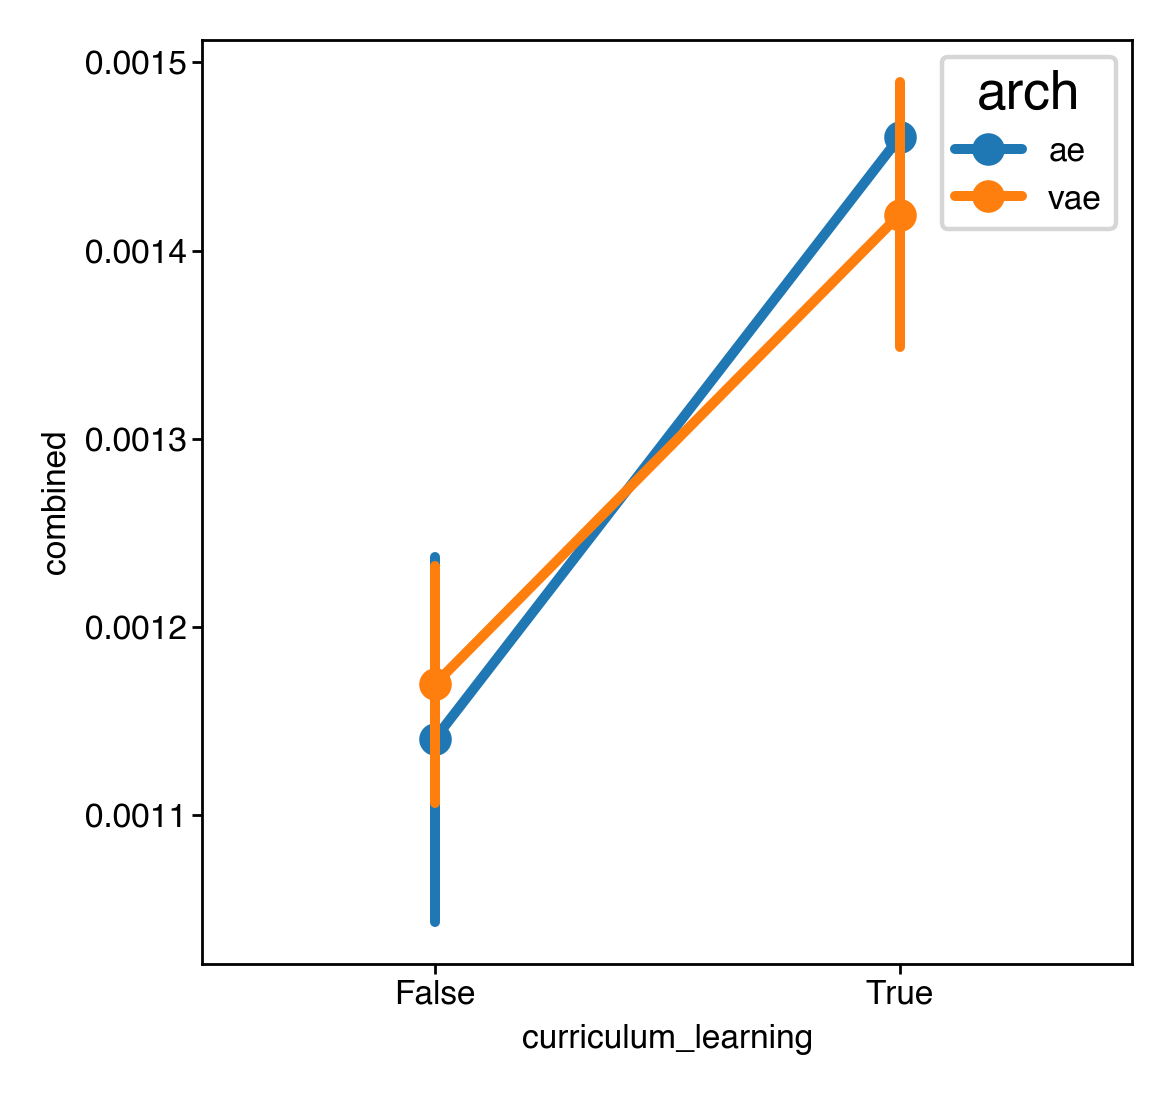

In [22]:
sns.pointplot(data=results, x='curriculum_learning', y='combined', hue='arch')

<Axes: xlabel='use_fft', ylabel='combined'>

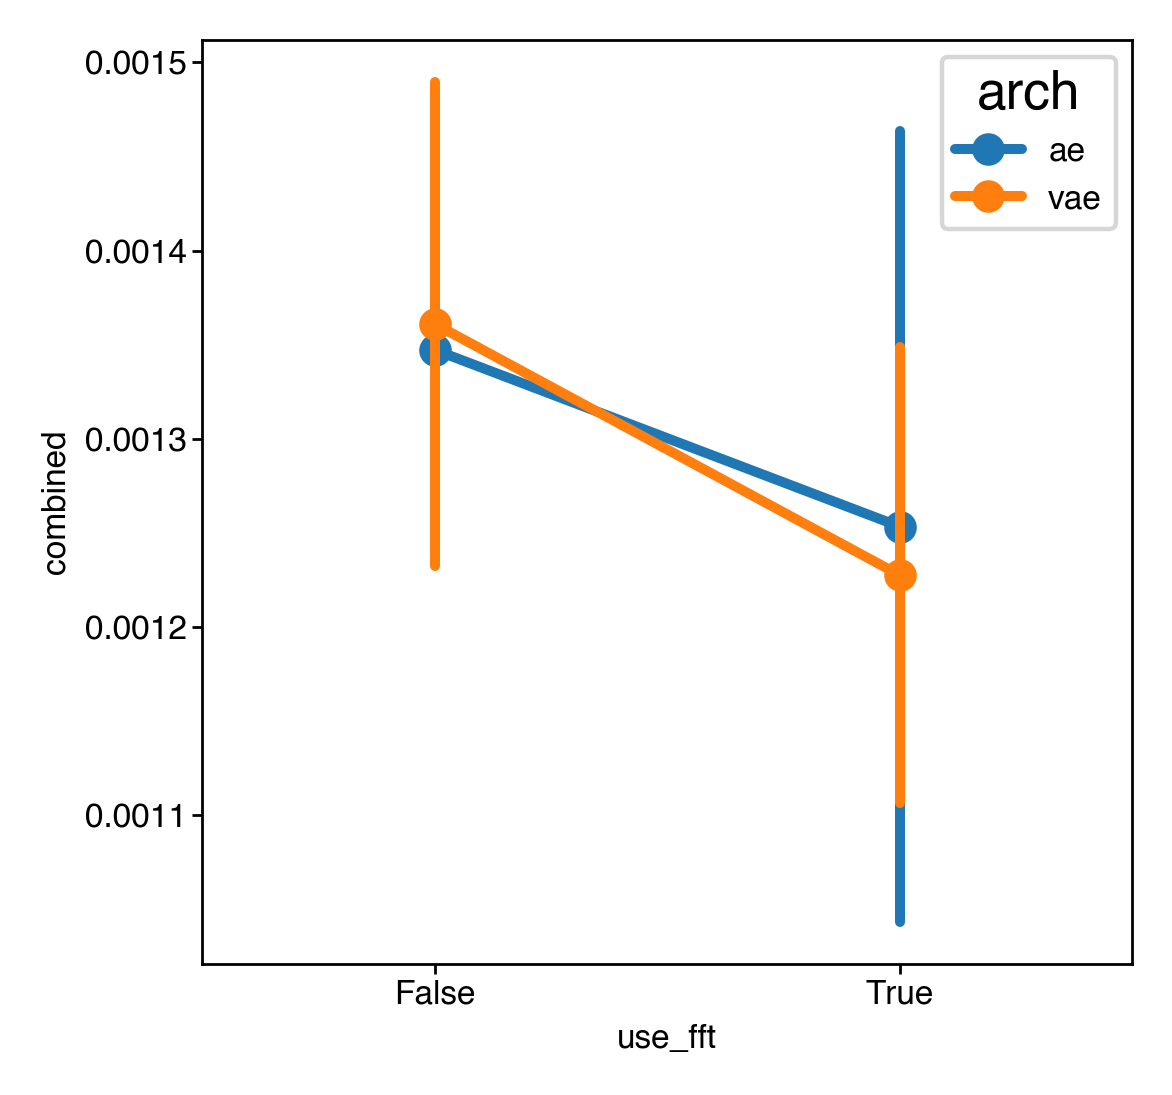

In [23]:
sns.pointplot(data=results, x='use_fft', y='combined', hue='arch')

<Axes: xlabel='arch', ylabel='combined'>

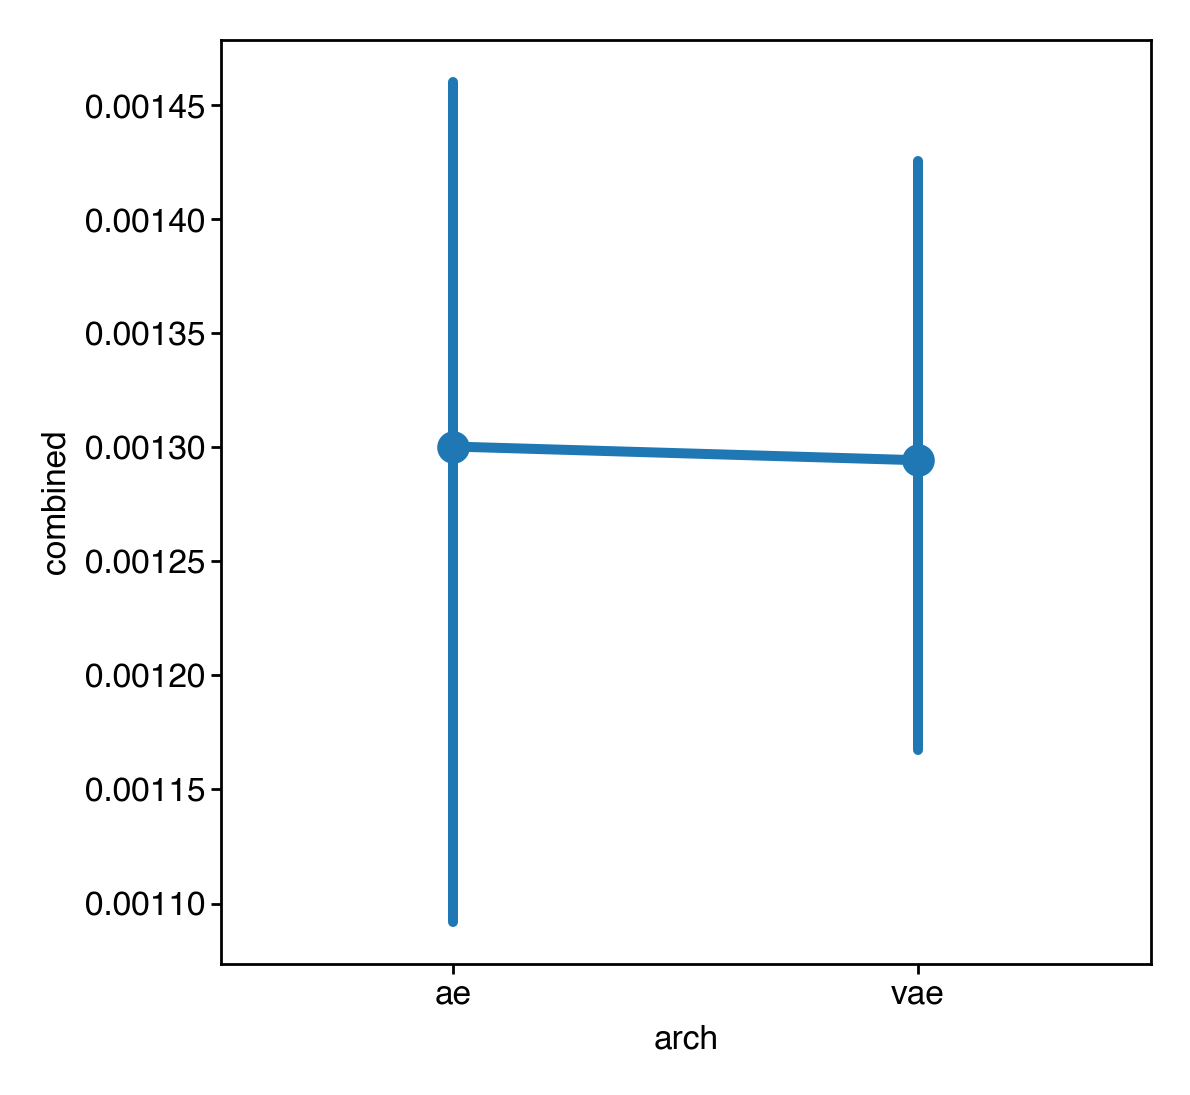

In [24]:
sns.pointplot(data=results, x='arch', y='combined')

In [25]:
grouped_files = groupby(lambda x: x.parents[2], metrics)
dfs = valmap(lambda x: pd.concat([pd.read_csv(f) for f in x]).set_index('step').sort_index(), grouped_files)

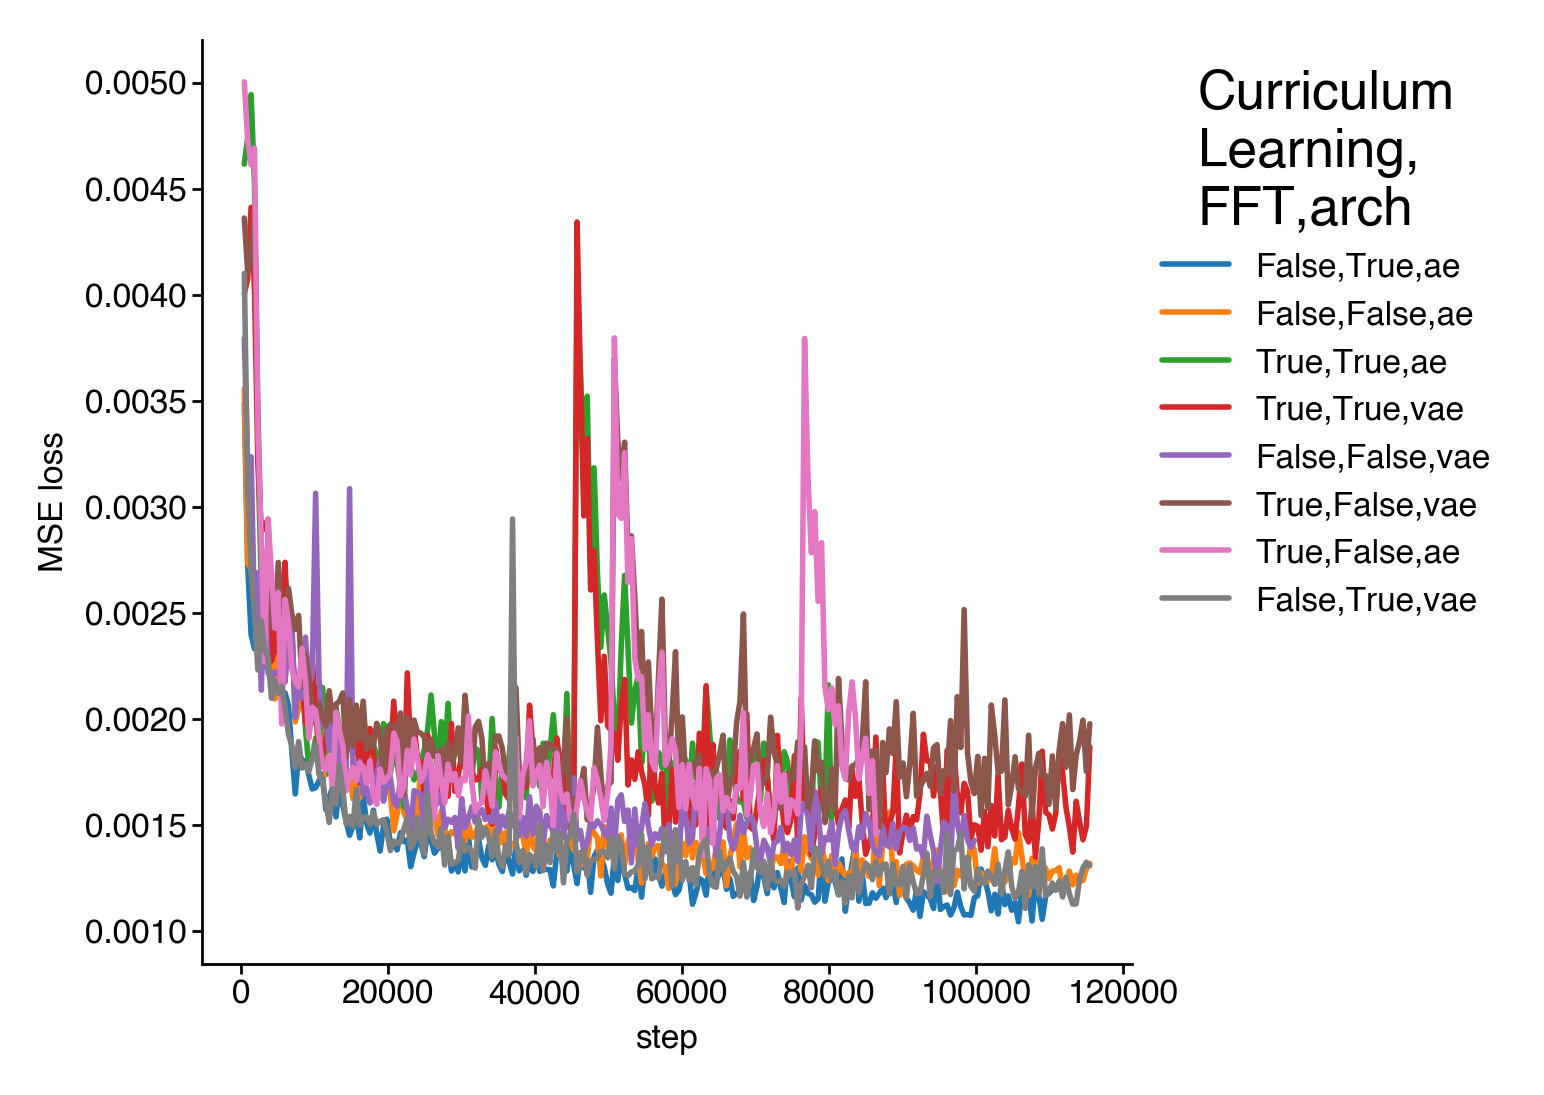

In [26]:
for k, v in dfs.items():
    config = toml.load(k / "config.toml")
    arch = config['model']['lightning']['arch']
    label = str(config['model']['lightning']['use_curriculum_learning']) + "," + str(config['model'][arch]['use_fft_branch']) + f",{arch}"
    if arch == 'vae':
        col = 'val_mse_loss'
    else:
        col = 'val_loss'
    ax = v[col].dropna().plot(label=label)
ax.set(ylabel='MSE loss')
sns.despine()
legend(title="Curriculum\nLearning,\nFFT,arch")

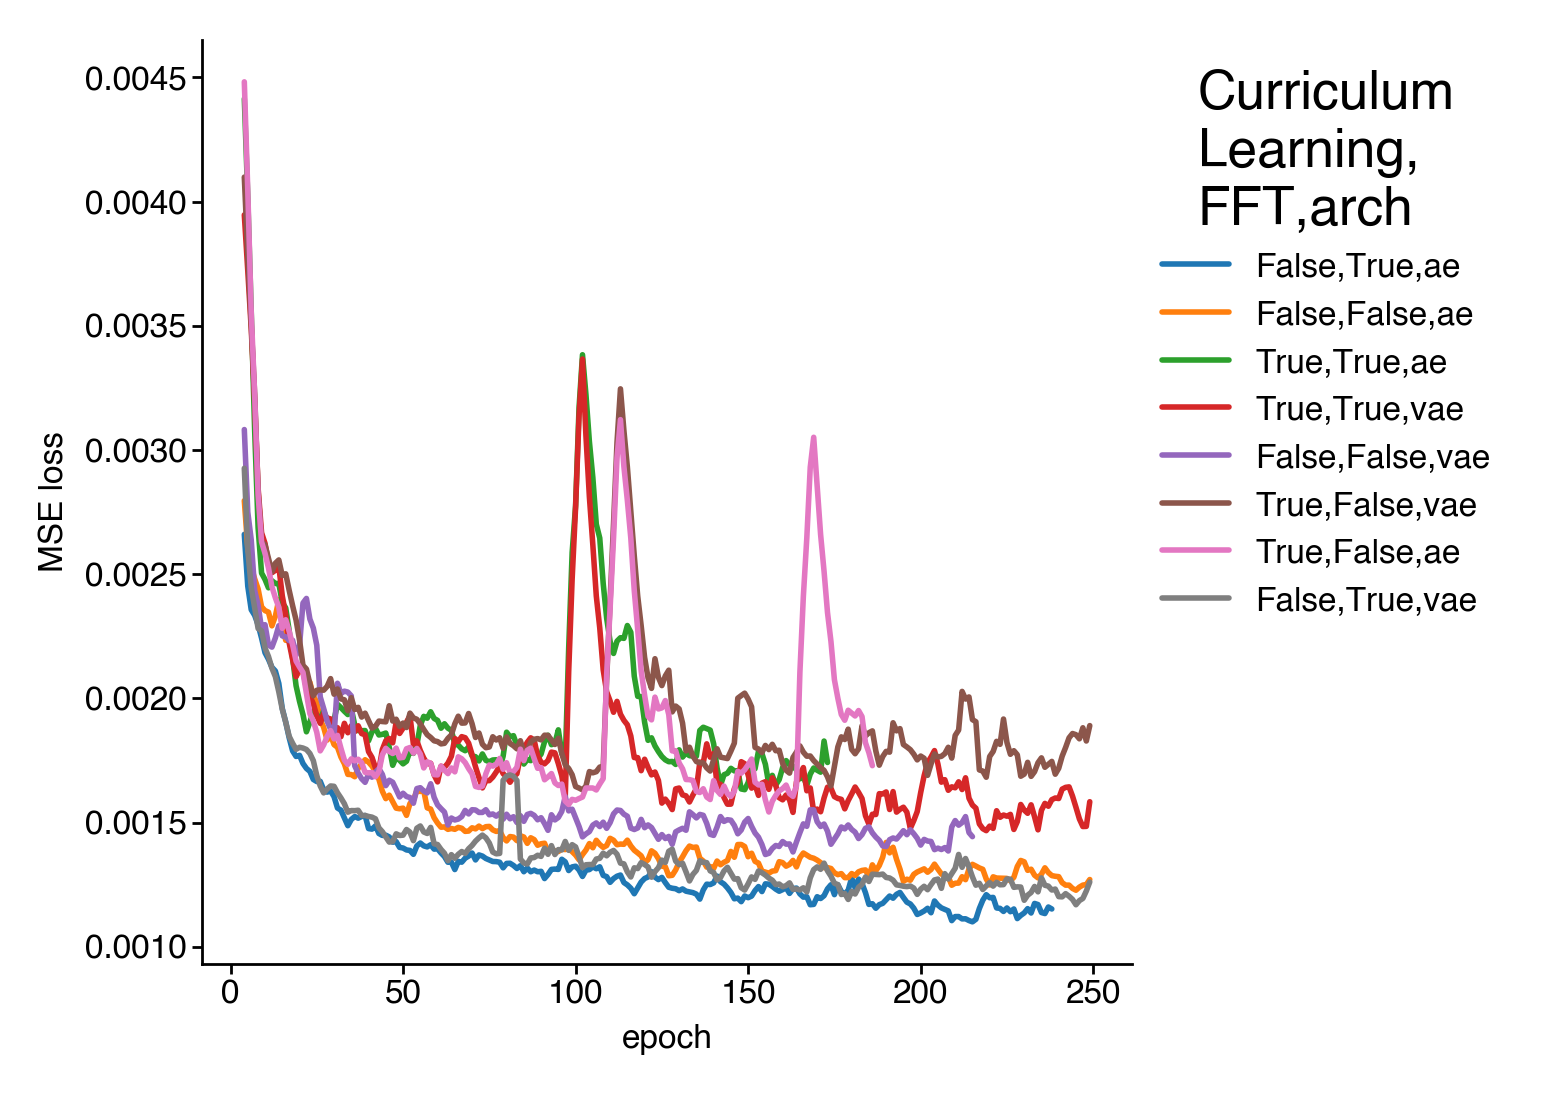

In [27]:
for k, v in dfs.items():
    config = toml.load(k / "config.toml")
    arch = config['model']['lightning']['arch']
    label = str(config['model']['lightning']['use_curriculum_learning']) + "," + str(config['model'][arch]['use_fft_branch']) + f",{arch}"
    if arch == 'vae':
        col = 'val_mse_loss'
    else:
        col = 'val_loss'
    ax = v.set_index('epoch')[col].dropna().rolling(5).mean().plot(label=label)
    # ax = v.set_index('epoch')[col].dropna().plot(label=label)
ax.set(ylabel='MSE loss')
sns.despine()
legend(title="Curriculum\nLearning,\nFFT,arch")

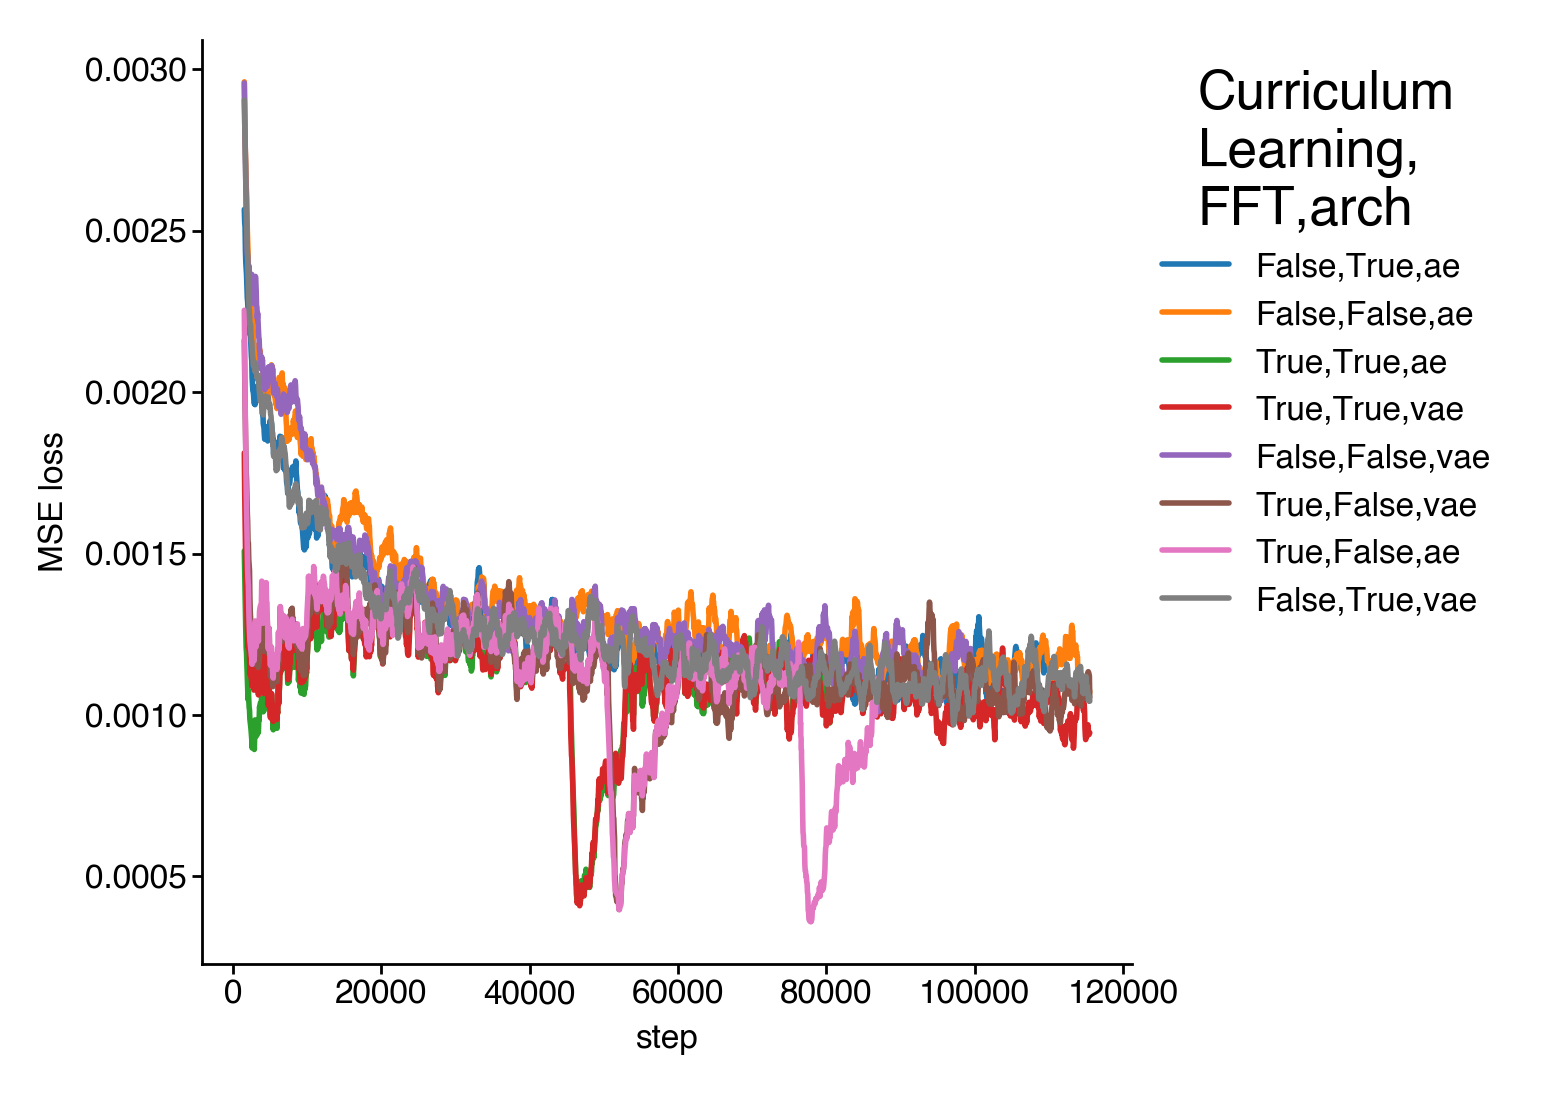

In [28]:
max_step = max(x.index.max() for x in dfs.values())

for k, v in dfs.items():
    config = toml.load(k / "config.toml")
    arch = config['model']['lightning']['arch']
    label = str(config['model']['lightning']['use_curriculum_learning']) + "," + str(config['model'][arch]['use_fft_branch']) + f",{arch}"
    if arch == 'vae':
        col = 'mse_loss'
    else:
        col = 'train_loss'
    ax = v.loc[:max_step, col].dropna().iloc[10:].rolling(21).mean().plot(label=label)
ax.set(ylabel='MSE loss')
sns.despine()
legend(title="Curriculum\nLearning,\nFFT,arch")